# Figure 10 - Effects of sonophore membrane coverage on neural responses

### Imports

In [2]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PySONIC.utils import logger, si_format
from PySONIC.postpro import prependDataFrame
from PySONIC.plt import TimeSeriesPlot
from PySONIC.core import NeuronalBilayerSonophore, PulsedProtocol, AcousticDrive
from PySONIC.neurons import getPointNeuron
from ExSONIC.core import Node, surroundedSonophore, SectionAcousticSource
from ExSONIC.batches import CoverageTitrationBatch
from utils import saveFigsAsPDF, subdirectory

logger.setLevel(logging.INFO)

### Functions

### Data sub-directory

In [5]:
subdir = subdirectory('coverage')

### Plot parameters

In [6]:
figindex = 10
fs = 12
tracefig_size = (8, 6)
thrfig_size = (6, 5)
figs = {}

### Simulation parameters

In [7]:
pneuron = getPointNeuron('RS')
a = 32e-9       # m
Fdrive = 500e3  # Hz
DC = 1.0
deff = 100e-9   # m
rs = 1e2        # Ohm.cm

## Panel A: neural responses at 50% coverage

 28/04/2020 17:10:05: Node(CorticalRS, a=32.0 nm, fs=50%): simulation @ f = 500kHz, A = 50.00kPa, tstim = 100ms, toffset = 50ms
 28/04/2020 17:10:05: RadialModel(CorticalRS, innerR32.0nm, outerR45.3nm, depth100nm, rs1.0e+02Ohm.cm).periphery: R*Am = 4.5e-05 Ohm.cm2 -> bounded to 1.0e+02 Ohm.cm2
 28/04/2020 17:10:05: RadialModel(CorticalRS, innerR32.0nm, outerR45.3nm, depth100nm, rs1.0e+02Ohm.cm).center: R*Am = 4.5e-05 Ohm.cm2 -> bounded to 1.0e+02 Ohm.cm2
 28/04/2020 17:10:05: RadialModel(CorticalRS, innerR32.0nm, outerR45.3nm, depth100nm, rs1.0e+02Ohm.cm, a=32.0 nm, fs=100%).periphery: R*Am = 4.5e-05 Ohm.cm2 -> bounded to 1.0e+02 Ohm.cm2
 28/04/2020 17:10:05: RadialModel(CorticalRS, innerR32.0nm, outerR45.3nm, depth100nm, rs1.0e+02Ohm.cm, a=32.0 nm, fs=100%).center: R*Am = 4.5e-05 Ohm.cm2 -> bounded to 1.0e+02 Ohm.cm2
 28/04/2020 17:10:05: RadialModel(CorticalRS, innerR32.0nm, outerR45.3nm, depth100nm, rs1.0e+02Ohm.cm, a=32.0 nm, fs=100%): simulation @ SectionAcousticSource(sec_id=cent

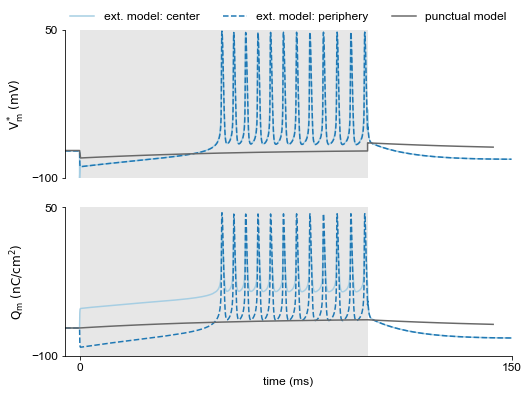

In [11]:
# Stimulation parameters
Adrive = 50e3   # kPa
cov = 0.5
pp = PulsedProtocol(100e-3, 50e-3)

# Simulate punctual SONIC model with specific membrane coverage
punctual_model = Node(pneuron, a=a, fs=cov)
punctual_data, _ = punctual_model.simulate(AcousticDrive(Fdrive, Adrive), pp)

# Simulate extended SONIC model with specific membrane coverage
ext_model = surroundedSonophore(pneuron, a, cov, rs, depth=deff)
ext_data, _ = ext_model.simulate(SectionAcousticSource('center', Fdrive, Adrive), pp)

# Add onset to solutions
tonset = -5e-3
punctual_data = prependDataFrame(punctual_data, tonset=tonset)
for k, df in ext_data.items():
    ext_data[k] = prependDataFrame(df, tonset=tonset)

# Get stimulus patches
t = punctual_data['t'].values  # s
stimon = punctual_data['stimstate'].values
pulse = TimeSeriesPlot.getStimPulses(t, stimon)[0]

# Create figure
fig, axes = plt.subplots(2, 1, figsize=tracefig_size)
for ax in axes:
    for key in ['right', 'top']:
        ax.spines[key].set_visible(False)
    ax.set_xlim(tonset * 1e3, (pp.tstop) * 1e3)
    ax.set_ylim(-100, 50)
    ax.set_yticks(ax.get_ylim())
    ax.axvspan(pulse[0] * 1e3, pulse[1] * 1e3, edgecolor='none', facecolor='#8A8A8A', alpha=0.2)
ax = axes[0]
ax.set_ylabel('$\\rm V_m^*\ (mV)$', fontsize=fs)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)
ax = axes[1]
ax.set_xlabel('time (ms)', fontsize=fs)
ax.set_ylabel('$\\rm Q_m\ (nC/cm^2)$', fontsize=fs)
ax.set_xticks([0, (pp.tstop) * 1e3])
ax.set_xticklabels(['{:.0f}'.format(x) for x in ax.get_xticks()])

# Plot membrane potential and charge density profiles
colors = plt.get_cmap('Paired').colors[:2]
linestyles = ['-', '--']
for i, (key, df) in enumerate(ext_data.items()):
    axes[0].plot(df['t'] * 1e3, df['Vm'], linestyles[i], c=colors[i], label=f'ext. model: {key}')
    axes[1].plot(df['t'] * 1e3, df['Qm'] * 1e5, linestyles[i], c=colors[i])
axes[0].plot(t * 1e3, punctual_data['Vm'], c='dimgrey', label='punctual model')
axes[1].plot(t * 1e3, punctual_data['Qm'] * 1e5, c='dimgrey')

# Add legend
axes[0].legend(
    frameon=False, fontsize=fs, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    ncol=3, mode='expand', borderaxespad=0.)

# Post-process figure
for ax in axes:
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)

figs['a'] = fig

## Panel B: threshold curves

Comparison of excitation threshold amplitudes of the punctual and nanoscale spatially-extended SONIC models for a range of sonophore coverage fractions.**The rendering may take a few seconds...**
 

In [10]:
# Stimulation parameters
pp = PulsedProtocol(1.0, 0.)
drive = AcousticDrive(Fdrive)
source = SectionAcousticSource('center', f=Fdrive)
cov_range = np.linspace(1, 99, 99)
out_key = 'Athr (Pa)'

# Compute threshold amplitudes with point-neuron model
batch0D = CoverageTitrationBatch(
    out_key, '0D',
    lambda fs: Node(pneuron, a=a, fs=fs * 1e-2),
    drive, pp, cov_range, root=subdir)
Athr0D = batch0D.run()

# Compute threshold amplitudes with spatially-extended model
batch1D = CoverageTitrationBatch(
    out_key, '1D',
    lambda fs: surroundedSonophore(pneuron, a, fs * 1e-2, rs, depth=deff),
    source, pp, cov_range, root=subdir)
Athr1D = batch1D.run()

# Plot threshold curves as a function of coverage fraction, for various sub-membrane depths
fig, ax = plt.subplots(figsize=thrfig_size)
ax.set_xlabel('sonophore membrane coverage (%)', fontsize=fs)
ax.set_ylabel('amplitude (kPa)', fontsize=fs)
ax.plot(cov_range, Athr0D * 1e-3, c='dimgrey', label='punctual model')
ax.plot(cov_range, Athr1D * 1e-3, c='C0', label='extended model')
ax.set_yscale('log')
ax.set_xlim(0, 100)
ax.set_ylim(1e1, 6e2)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.legend(frameon=False, fontsize=fs, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=2, mode='expand', borderaxespad=0.)

figs['b'] = fig

KeyboardInterrupt: 

### Save figure panels

Save figure panels as **pdf** in the *figs* sub-folder:

In [ ]:
saveFigsAsPDF(figs, figindex)